Ok, what do we have over there. Lets start with the first layer. We have two fixed distributions over there:

- Uniform in case of raw coordinates input
- Other, in case of positional encoding

# Init

In [2]:
import rff

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import math

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2, device='cpu'):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen, device=device)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
import lovely_tensors as lt
lt.monkey_patch()

In [4]:
def init_splitact_Wb_randn(insize, outsize, device='cpu'):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)*0.01
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device='cpu'):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = (torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device='cpu'):
    return init_splitact_Wb_pytorch(insize, outsize, device)

def U(*shape):
    x = torch.rand(*shape)
    x = (x-0.5)*2.
    return x

def splitlayer_forward(x, W, b):
    preact = x@W + b
    preact_tanh, preact_sigmoid, preact_sin, preact_cos = preact.chunk(4, dim=-1)
    act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
    h = act_tanh*act_sigmoid*act_sin*act_cos

    return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

In [5]:
import plotly.express as px
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a

# Positional encoding distribution

In [5]:
encoded_size = 256

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
uvs = get_mgrid(512)
uvs_enc = encoding(uvs)

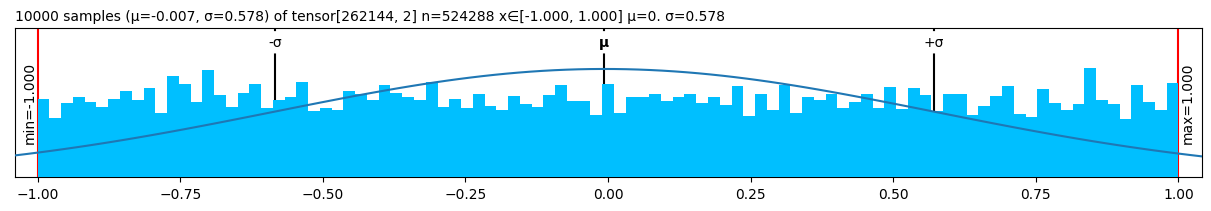

In [6]:

uvs.plt

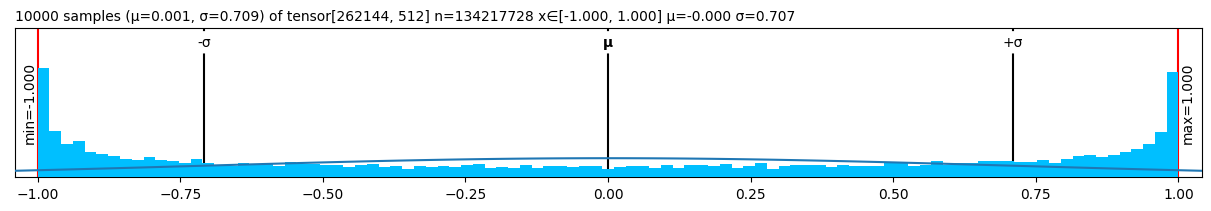

In [7]:

uvs_enc.plt

In [8]:
display(rff.layers.GaussianEncoding(sigma=100.0, input_size=2, encoded_size=encoded_size)(uvs).plt)

In [9]:
# for encoded_size in [2, 8, 16, 32, 64, 128, 256, 512, 1024]:
#     print(encoded_size)
#     display(rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)(uvs).plt)

In [10]:
W, b = init_splitact_Wb_randn(insize=encoded_size*2, outsize=64)

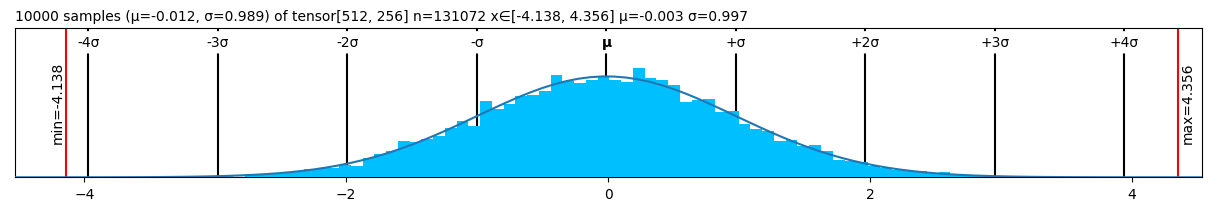

In [11]:
W.plt

In [12]:
h, acts = splitlayer_forward(uvs_enc, W, b)

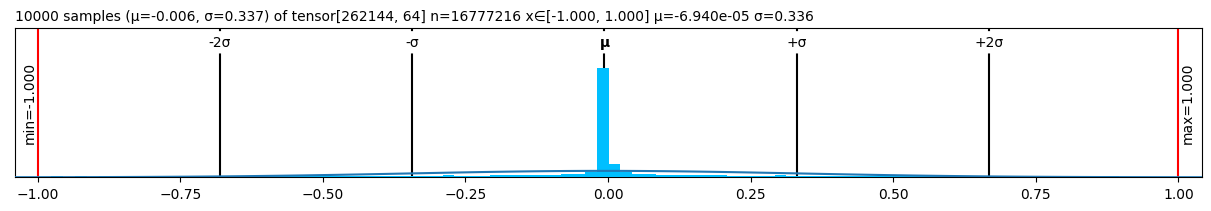

In [13]:
h.plt

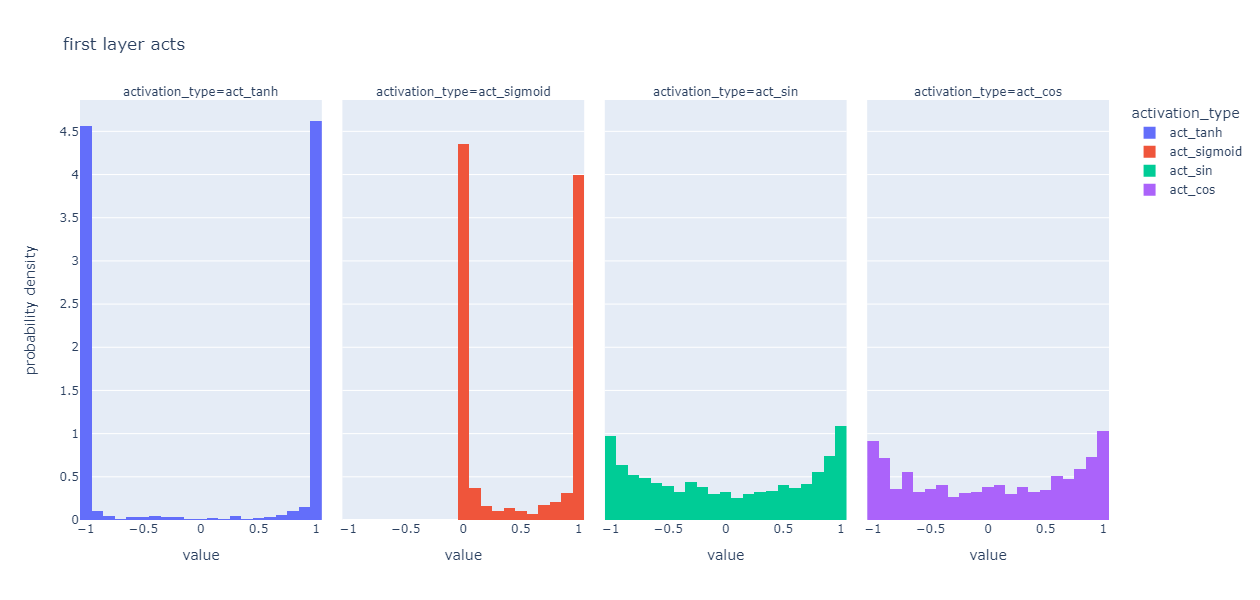

In [14]:
title='first layer acts'
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

preact_tanh = to_np(preact_tanh)
preact_sigmoid = to_np(preact_sigmoid)
preact_sin = to_np(preact_sin)
preact_cos = to_np(preact_cos)
act_tanh = to_np(act_tanh)
act_sigmoid = to_np(act_sigmoid)
act_sin = to_np(act_sin)
act_cos = to_np(act_cos)

# Create a dataframe from your arrays
data = {
    # "preact_tanh": preact_tanh,
    # "preact_sigmoid": preact_sigmoid,
    # "preact_sin": preact_sin,
    # "preact_cos": preact_cos,
    "act_tanh": act_tanh,
    "act_sigmoid": act_sigmoid,
    "act_sin": act_sin,
    "act_cos": act_cos,
}

df = pd.DataFrame(data)

# Melt the dataframe to a long format for easier plotting
df_melted = df.melt(var_name="activation_type", value_name="value")

# Plot histograms using Plotly Express
fig = px.histogram(
    df_melted,
    x="value",
    color="activation_type",
    facet_col="activation_type",
    facet_col_wrap=4,
    histnorm="probability density",
    title=title,
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)

# fig.update_yaxes(range=[0, 1.5])

# What facts do we know?

In [15]:
# - Input to the `tanh` and `sigmoid` should be in the non-saturation zone

Ok, lets have tanh distribution to be a ~normal with `std=0.42`

In [16]:
encoded_size = 256*2

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
uvs = get_mgrid(512)
uvs_enc = encoding(uvs)

insize=encoded_size*2
outsize=64
device = 'cpu'

first_chunk_idx = (torch.arange(outsize) + 0.*torch.arange(outsize)).long()
second_chunk_idx = (torch.arange(outsize) + 1.*torch.arange(outsize)).long()


In [17]:
W = torch.randn(insize, outsize*4, device=device)
b = torch.randn(outsize*4, device=device)*1e-6

W[:, first_chunk_idx] = torch.randn_like(W[:, first_chunk_idx]) * 0.02

h, acts = splitlayer_forward(uvs_enc, W, b)

act_tanh


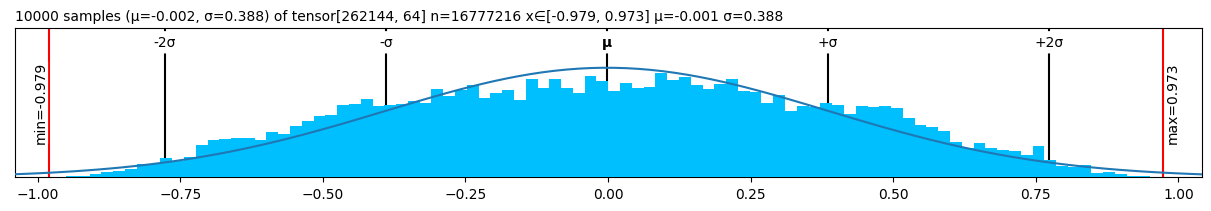

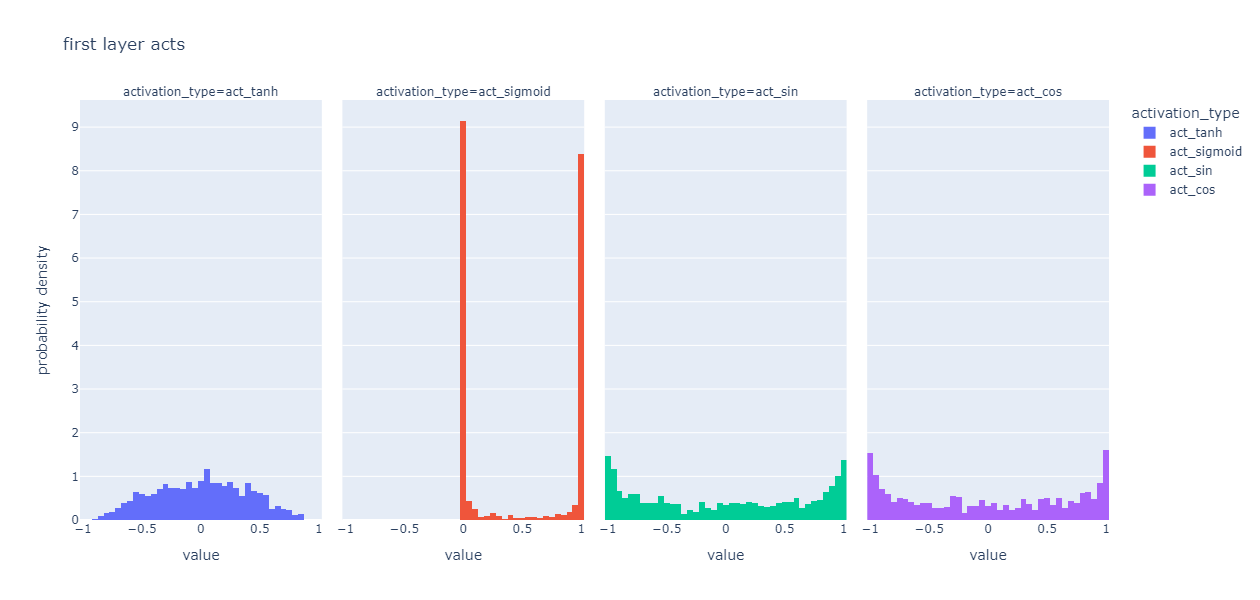

In [18]:
title='first layer acts'
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

print('act_tanh')
display(act_tanh.plt)

preact_tanh = to_np(preact_tanh)
preact_sigmoid = to_np(preact_sigmoid)
preact_sin = to_np(preact_sin)
preact_cos = to_np(preact_cos)
act_tanh = to_np(act_tanh)
act_sigmoid = to_np(act_sigmoid)
act_sin = to_np(act_sin)
act_cos = to_np(act_cos)

# Create a dataframe from your arrays
data = {
    # "preact_tanh": preact_tanh,
    # "preact_sigmoid": preact_sigmoid,
    # "preact_sin": preact_sin,
    # "preact_cos": preact_cos,
    "act_tanh": act_tanh,
    "act_sigmoid": act_sigmoid,
    "act_sin": act_sin,
    "act_cos": act_cos,
}

df = pd.DataFrame(data)

# Melt the dataframe to a long format for easier plotting
df_melted = df.melt(var_name="activation_type", value_name="value")

# Plot histograms using Plotly Express
fig = px.histogram(
    df_melted,
    x="value",
    color="activation_type",
    facet_col="activation_type",
    facet_col_wrap=4,
    histnorm="probability density",
    title=title,
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)

# fig.update_yaxes(range=[0, 1.5])
# fig.update_xaxes(range=[-1.5, 1.5])

## Classical tanh scenario

In [19]:
uvs_enc.plt

In [21]:
hs = 4

encoded_size = hs//2

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
uvs = get_mgrid(512)
uvs_enc = encoding(uvs)

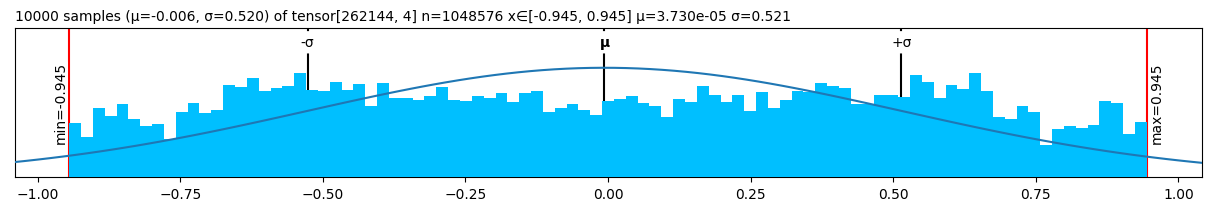

In [22]:
x = U(10_000, hs)
x = uvs_enc

gain = (3/3) # since tanh
W = torch.randn(hs, hs) * (gain/(hs)**0.5)

h = (x@W)
a = h.tanh()

display(x.plt)
display(h.plt)
display(a.plt)

## grid search: is it possible to have a fixed distribution over all `fan_in` just with a `gain` knob?

In [23]:
device = 'cuda:0'

In [24]:
desired_std_out = 0.5

In [50]:
fan_ins = 2**(torch.arange(15)+1)
fan_ins = (2**torch.linspace(1, 12, steps=50)).int()*2
fan_ins

tensor[50] i32 x∈[4, 8192] μ=1.136e+03 σ=1.950e+03

In [51]:
from tqdm.auto import tqdm

In [52]:
def evaluate_stds_for_given_gain(gain):
    stds = []

    for fan_in in (fan_ins):
        encoded_size = fan_in//2

        encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size).to(device)
        uvs = get_mgrid(128, device=device)
        uvs_enc = encoding(uvs)


        W = torch.randn(fan_in, fan_in, device=device) * (gain/(fan_in)**0.5)

        h = (uvs_enc@W)
        a = h.tanh()

        stds.append( a.std() )

    return torch.tensor(stds)

In [55]:
stds.mean()

tensor 0.521

In [57]:
stds = []
gains = torch.linspace(0.1, 10, 20)
for gain in tqdm(gains):
    stds.append( evaluate_stds_for_given_gain(gain).mean() )

  0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
plt.plot(gains, stds)

In [64]:
min_std_err_idx = (torch.tensor(stds) - desired_std_out).abs().argmin()

best_gain = gains[min_std_err_idx]
best_std = stds[min_std_err_idx]
print(f'best_gain={best_gain} best_std={best_std}')

best_gain=1.142105221748352 best_std=0.5610570907592773


In [69]:
stds = []
stds_stds = []
gains = torch.linspace(0.8, 1.1, 20)
for gain in tqdm(gains):
    stds_batch = evaluate_stds_for_given_gain(gain)
    stds.append( stds_batch.mean() )
    stds_stds.append( stds_batch.std() )    

  0%|          | 0/20 [00:00<?, ?it/s]

best_gain=0.9263157844543457 best_std=0.49730509519577026


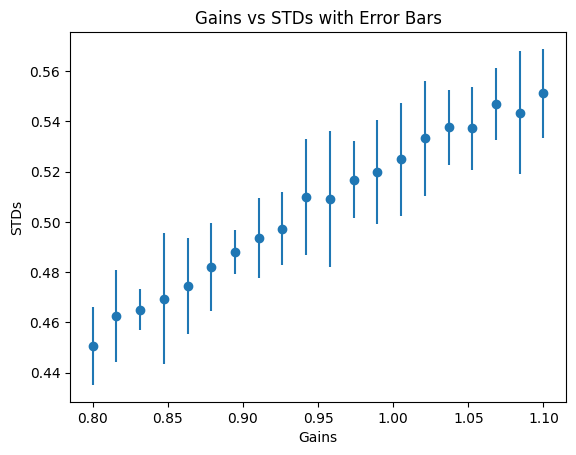

In [73]:
min_std_err_idx = (torch.tensor(stds) - desired_std_out).abs().argmin()

best_gain = gains[min_std_err_idx]
best_std = stds[min_std_err_idx]
print(f'best_gain={best_gain} best_std={best_std}')

fig, ax = plt.subplots()
ax.errorbar(gains, stds, yerr=stds_stds, fmt='o')
ax.set_xlabel('Gains')
ax.set_ylabel('STDs')
ax.set_title('Gains vs STDs with Error Bars')
plt.show()

In [74]:
stds = []
stds_stds = []
gains = torch.linspace(0.926-0.05, 0.926+0.05, 40)
for gain in tqdm(gains):
    stds_batch = evaluate_stds_for_given_gain(gain)
    stds.append( stds_batch.mean() )
    stds_stds.append( stds_batch.std() )    

  0%|          | 0/40 [00:00<?, ?it/s]

best_gain=0.9349743723869324 best_std=0.4994068145751953


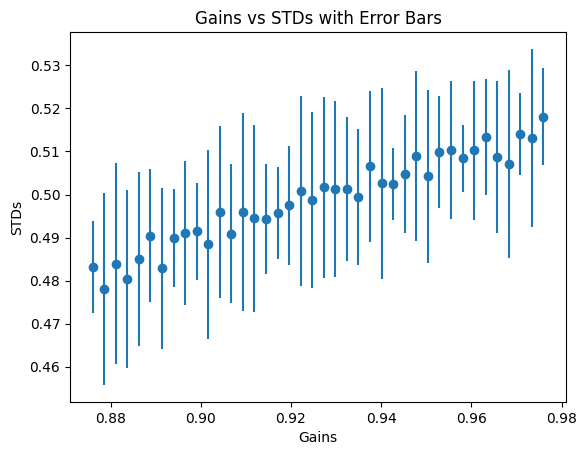

In [75]:
min_std_err_idx = (torch.tensor(stds) - desired_std_out).abs().argmin()

best_gain = gains[min_std_err_idx]
best_std = stds[min_std_err_idx]
print(f'best_gain={best_gain} best_std={best_std}')

fig, ax = plt.subplots()
ax.errorbar(gains, stds, yerr=stds_stds, fmt='o')
ax.set_xlabel('Gains')
ax.set_ylabel('STDs')
ax.set_title('Gains vs STDs with Error Bars')
plt.show()

## verifying the result: gain=0.935

In [80]:
hs = 64

encoded_size = hs//2

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
uvs = get_mgrid(512)
uvs_enc = encoding(uvs)

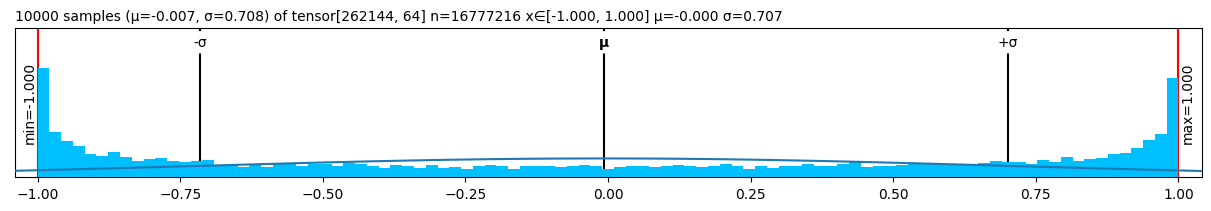

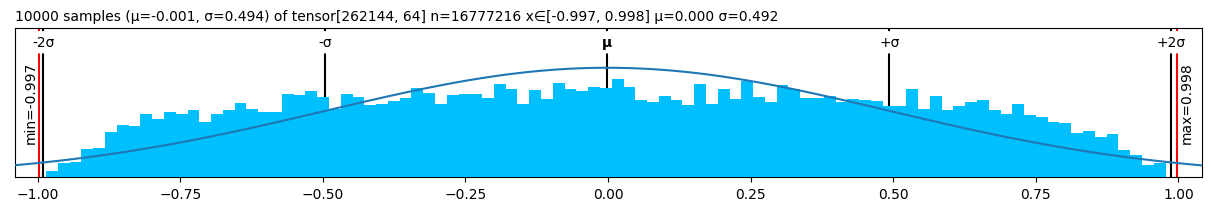

In [82]:
x = U(10_000, hs)
x = uvs_enc

gain = (0.9) # since tanh
W = torch.randn(hs, hs) * (gain/(hs)**0.5)

h = (x@W)
a = h.tanh()

display(x.plt)
display(h.plt)
display(a.plt)

## Sigmoid

In [104]:
hs = 64

encoded_size = hs//2

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
uvs = get_mgrid(512)
uvs_enc = encoding(uvs)

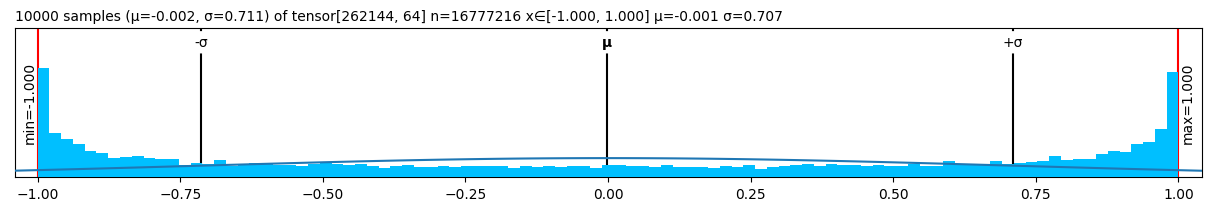

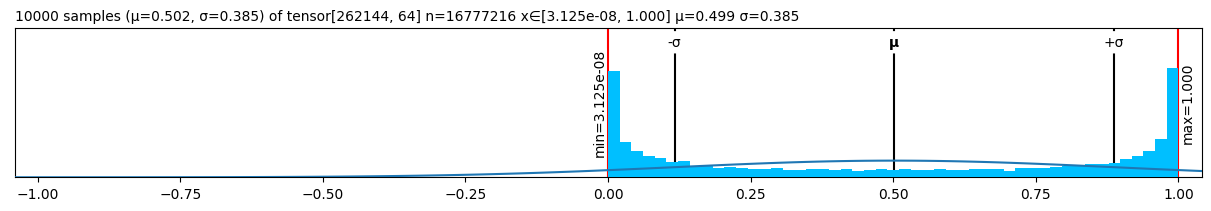

In [106]:
x = U(10_000, hs)
x = uvs_enc

gain = (5) # since tanh
W = torch.randn(hs, hs) * (gain/(hs)**0.5)

h = (x@W)
a = h.sigmoid()

display(x.plt)
display(h.plt)
display(a.plt)

In [107]:
def evaluate_sigmoid_stds_for_given_gain(gain):
    stds = []

    for fan_in in (fan_ins):
        encoded_size = fan_in//2

        encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size).to(device)
        uvs = get_mgrid(128, device=device)
        uvs_enc = encoding(uvs)


        W = torch.randn(fan_in, fan_in, device=device) * (gain/(fan_in)**0.5)

        h = (uvs_enc@W)
        a = h.sigmoid()

        stds.append( a.std() )

    return torch.tensor(stds)

In [109]:
evaluate_sigmoid_stds_for_given_gain(10.)

tensor[30] x∈[0.433, 0.448] μ=0.442 σ=0.002

## Generalize search method for any given input distribution and activation function. 

In [77]:
fan_ins = (2**torch.linspace(1, 11, steps=30)).int()*2
fan_ins

tensor[30] i32 x∈[4, 4096] μ=640.800 σ=1.047e+03

In [111]:
desired_std = 0.2
f = lambda gain: evaluate_sigmoid_stds_for_given_gain(gain).mean() - desired_std

from_x, to_x = 0, 10
tol = 1e-2

while (to_x - from_x) > tol:
    c = (to_x + from_x) / 2
    f_at_c = f(c)
    
    if f_at_c > 0:
        to_x = c
    else:
        from_x = c
    
    # print(f_at_c, to_x - from_x)
    print(f'f({c:.3f})={f_at_c} in [{from_x:.3f}, {to_x:.3f}]')

f(5.000)=0.18608172237873077 in [0.000, 5.000]
f(2.500)=0.09369529783725739 in [0.000, 2.500]
f(1.250)=-0.012937605381011963 in [1.250, 2.500]
f(1.875)=0.052665308117866516 in [1.250, 1.875]
f(1.562)=0.024517029523849487 in [1.250, 1.562]
f(1.406)=0.0043798089027404785 in [1.250, 1.406]
f(1.328)=-0.001648247241973877 in [1.328, 1.406]
f(1.367)=0.0025211721658706665 in [1.328, 1.367]
f(1.348)=0.00272272527217865 in [1.328, 1.348]
f(1.338)=0.0001744776964187622 in [1.328, 1.338]


In [73]:
def generate_posenc_input(fan_in):
    encoded_size = fan_in//2

    encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size).to(device)
    uvs = get_mgrid(128, device=device)
    uvs_enc = encoding(uvs)
    return uvs_enc

In [145]:
generate_uniform_input = lambda fan_in: U(10_000, fan_in).to(device)

In [74]:
class GaiEvaluator:
    def __init__(self, cfg):
        self.cfg = cfg
        
    def __call__(self, gain):
        stds = []

        for fan_in in (fan_ins):
            x = self.cfg['input_distribution_generator'](fan_in)

            W = torch.randn(fan_in, fan_in, device=device) * (gain/(fan_in)**0.5)

            h = (x@W)
            a = self.cfg['activation_function'](h)

            stds.append( a.std() )

        return torch.tensor(stds)

In [75]:
def find_gai_root(cfg):
    gai_evaluator = GaiEvaluator(cfg)
    f = lambda gain: gai_evaluator(gain).mean() - cfg['desired_std']

    from_x, to_x = cfg['search_interval']
    tol = cfg.get('tol', 1e-3)

    while (to_x - from_x) > tol:
        c = (to_x + from_x) / 2
        f_at_c = f(c)

        if f_at_c > 0:
            to_x = c
        else:
            from_x = c

        # print(f_at_c, to_x - from_x)
        print(f'f({c:.3f})={f_at_c+ cfg["desired_std"]} in [{from_x:.3f}, {to_x:.3f}]')

In [151]:
cfg = {
    'search_interval': (0, 10),
    'activation_function': torch.sigmoid,
    'desired_std': 0.2,
    'input_distribution_generator': generate_uniform_input
}

find_gai_root(cfg)

f(5.000)=0.36137497425079346 in [0.000, 5.000]
f(2.500)=0.2647789418697357 in [0.000, 2.500]
f(1.250)=0.1629992425441742 in [1.250, 2.500]
f(1.875)=0.2224530577659607 in [1.250, 1.875]
f(1.562)=0.1915692239999771 in [1.562, 1.875]
f(1.719)=0.2055300921201706 in [1.562, 1.719]
f(1.641)=0.19896896183490753 in [1.641, 1.719]
f(1.680)=0.20205825567245483 in [1.641, 1.680]
f(1.660)=0.20290130376815796 in [1.641, 1.660]
f(1.650)=0.20039179921150208 in [1.641, 1.650]
f(1.646)=0.19964054226875305 in [1.646, 1.650]
f(1.648)=0.19943870604038239 in [1.648, 1.650]
f(1.649)=0.19817334413528442 in [1.649, 1.650]
f(1.650)=0.19984765350818634 in [1.650, 1.650]


In [152]:
cfg = {
    'search_interval': (0, 10),
    'activation_function': torch.tanh,
    'desired_std': 0.5,
    'input_distribution_generator': generate_uniform_input
}

find_gai_root(cfg)

f(5.000)=0.8572709560394287 in [0.000, 5.000]
f(2.500)=0.7247982621192932 in [0.000, 2.500]
f(1.250)=0.5225602984428406 in [0.000, 1.250]
f(0.625)=0.32258930802345276 in [0.625, 1.250]
f(0.938)=0.43913206458091736 in [0.938, 1.250]
f(1.094)=0.4856419861316681 in [1.094, 1.250]
f(1.172)=0.5097315311431885 in [1.094, 1.172]
f(1.133)=0.491702675819397 in [1.133, 1.172]
f(1.152)=0.5001060366630554 in [1.133, 1.152]
f(1.143)=0.5014634132385254 in [1.133, 1.143]
f(1.138)=0.5029751658439636 in [1.133, 1.138]
f(1.135)=0.4913947880268097 in [1.135, 1.138]
f(1.136)=0.4998588562011719 in [1.136, 1.138]
f(1.137)=0.49890050292015076 in [1.137, 1.138]


In [153]:
cfg = {
    'search_interval': (0, 10),
    'activation_function': torch.tanh,
    'desired_std': 0.5,
    'input_distribution_generator': generate_posenc_input
}

find_gai_root(cfg)

f(5.000)=0.8834927678108215 in [0.000, 5.000]
f(2.500)=0.7742181420326233 in [0.000, 2.500]
f(1.250)=0.5917953848838806 in [0.000, 1.250]
f(0.625)=0.37901875376701355 in [0.625, 1.250]
f(0.938)=0.5005303025245667 in [0.625, 0.938]
f(0.781)=0.44527679681777954 in [0.781, 0.938]
f(0.859)=0.47548744082450867 in [0.859, 0.938]
f(0.898)=0.48937278985977173 in [0.898, 0.938]
f(0.918)=0.49884679913520813 in [0.918, 0.938]
f(0.928)=0.5088899731636047 in [0.918, 0.928]
f(0.923)=0.4932803213596344 in [0.923, 0.928]
f(0.925)=0.5038058757781982 in [0.923, 0.925]
f(0.924)=0.4984169006347656 in [0.924, 0.925]
f(0.925)=0.5012484788894653 in [0.924, 0.925]


In [165]:
cfg = {
    'search_interval': (0, 10),
    'activation_function': torch.sigmoid,
    'desired_std': 0.2,
    'input_distribution_generator': generate_posenc_input
}

find_gai_root(cfg)

f(5.000)=0.3871432840824127 in [0.000, 5.000]
f(2.500)=0.29315051436424255 in [0.000, 2.500]
f(1.250)=0.19109033048152924 in [1.250, 2.500]
f(1.875)=0.24976930022239685 in [1.250, 1.875]
f(1.562)=0.22346273064613342 in [1.250, 1.562]
f(1.406)=0.20958881080150604 in [1.250, 1.406]
f(1.328)=0.1997840851545334 in [1.328, 1.406]
f(1.367)=0.2039969116449356 in [1.328, 1.367]
f(1.348)=0.20188789069652557 in [1.328, 1.348]
f(1.338)=0.20040439069271088 in [1.328, 1.338]
f(1.333)=0.19895032048225403 in [1.333, 1.338]
f(1.335)=0.19506028294563293 in [1.335, 1.338]
f(1.337)=0.20277243852615356 in [1.335, 1.337]
f(1.336)=0.19974693655967712 in [1.336, 1.337]


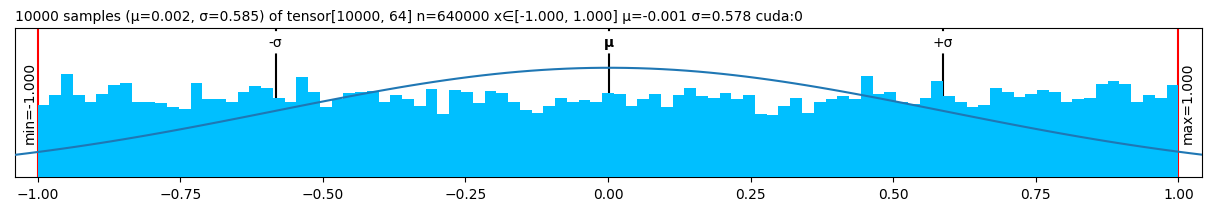

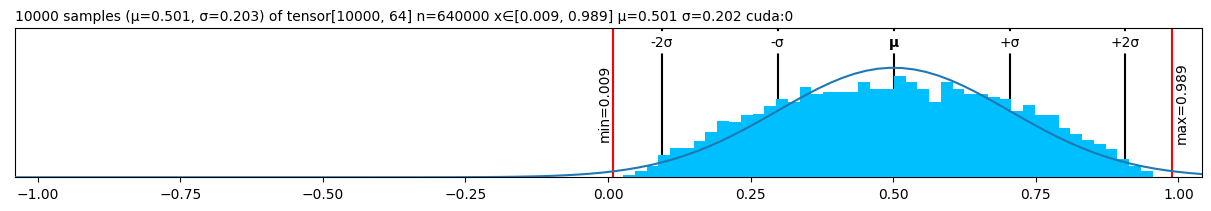

In [169]:
fan_in = 64
gain = 1.650

x = generate_uniform_input(fan_in)

W = torch.randn(fan_in, fan_in, device=device) * (gain/(fan_in)**0.5)

h = (x@W)
a = torch.sigmoid(h)

display(x.plt)
display(a.plt)

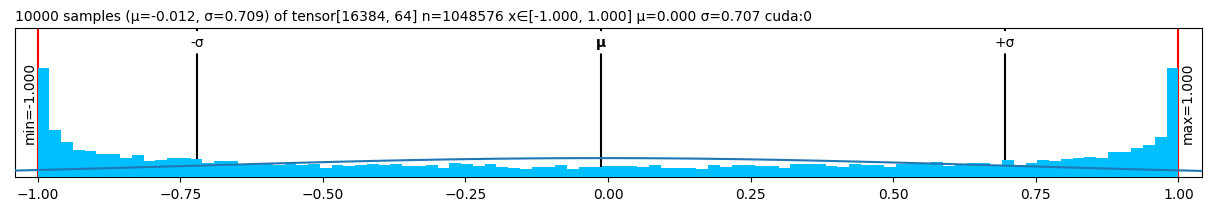

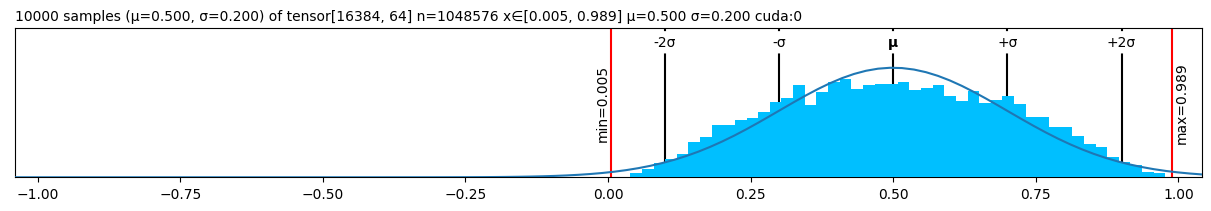

In [158]:
fan_in = 64
gain = 1.35

x = generate_posenc_input(fan_in)

W = torch.randn(fan_in, fan_in, device=device) * (gain/(fan_in)**0.5)

h = (x@W)
a = torch.sigmoid(h)

display(x.plt)
display(a.plt)

In [35]:
def init_splitnet_layer_00_posenc_input(W):
    tanh_gain = 0.925
    sigmoid_gain = 1.353

    W = torch.randn_like(W)
    fan_in = W.shape[0]
    fan_out = W.shape[1]
    assert fan_out % 4 == 0

    cs = fan_out//4 # chunk size
    W[:, :cs] = torch.randn_like(W[:, :cs]) * tanh_gain / (fan_in)**0.5
    W[:, cs:cs*2] = torch.randn_like(W[:, :cs]) * sigmoid_gain / (fan_in)**0.5
    return W


def init_splitnet_layer_00_uniform_input(*args, **kwargs):

    return _init_splitnet_layer_00(*args, **kwargs, tanh_gain = 1.137, sigmoid_gain = 1.65)


def _init_splitnet_layer_00(*shape, device='cpu', tanh_gain = 1.137, sigmoid_gain = 1.65):
    W = torch.randn(*shape, device=device)
    fan_in = W.shape[0]
    fan_out = W.shape[1]
    assert fan_out % 4 == 0

    cs = fan_out//4 # chunk size
    W[:, :cs] = torch.randn_like(W[:, :cs]) * tanh_gain / (fan_in)**0.5
    W[:, cs:cs*2] = torch.randn_like(W[:, :cs]) * sigmoid_gain / (fan_in)**0.5
    return W

In [8]:
device = 'cuda:0'

In [93]:
x = U(5_000, 2).to(device)
W1 = init_splitnet_layer_00_uniform_input(torch.randn(2, 64*4)).to(device)

In [94]:
Wtanh, Wsigm, Wsin, Wcos = W1.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = x@Wtanh
preact_sigmoid = x@Wsigm
preact_sin = x@Wsin
preact_cos = x@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h = act_tanh*act_sigmoid*act_sin*act_cos

In [95]:
preact_tanh.tanh().plt

In [96]:
h.plt

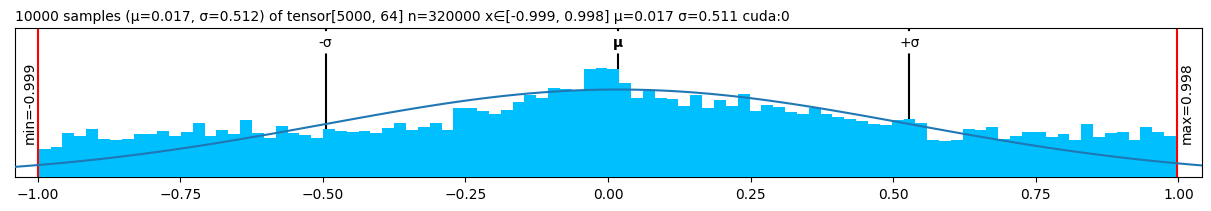

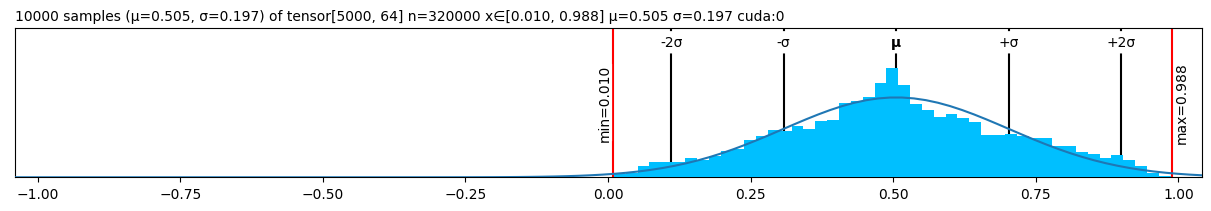

In [99]:
W2 = _init_splitnet_layer_00(64, 64*4, device=device, tanh_gain=5.5, sigmoid_gain=7.753)

# W2[:, :64] *= 2

Wtanh, Wsigm, Wsin, Wcos = W2.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = h@Wtanh
preact_sigmoid = h@Wsigm
preact_sin = h@Wsin
preact_cos = h@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h2 = act_tanh*act_sigmoid*act_sin*act_cos

display(act_tanh.plt)
display(act_sigmoid.plt)
display(h2.plt)

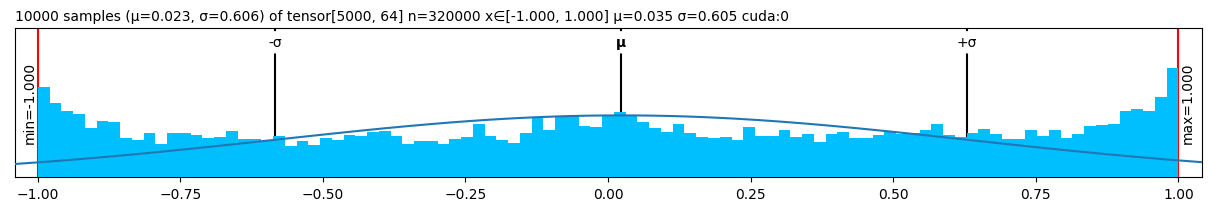

In [98]:
W2 = (torch.randn(64, 64*4)).to(device)

# W2[:, :64] *= 2

Wtanh, Wsigm, Wsin, Wcos = W2.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = h@Wtanh
preact_sigmoid = h@Wsigm
preact_sin = h@Wsin
preact_cos = h@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h2 = act_tanh*act_sigmoid*act_sin*act_cos

display(act_tanh.plt)
display(act_sigmoid.plt)

In [72]:
p = h.shape[0]*h.shape[1]

def sample_from_h(fan_in):
    return h.flatten()[:(p//fan_in)*fan_in].view(-1, fan_in)

In [86]:
cfg = {
    'search_interval': (0, 40),
    'activation_function': torch.tanh,
    'desired_std': 0.5,
    'input_distribution_generator': sample_from_h
}

find_gai_root(cfg)

f(20.000)=0.8059518337249756 in [0.000, 20.000]
f(10.000)=0.6625386476516724 in [0.000, 10.000]
f(5.000)=0.46048909425735474 in [5.000, 10.000]
f(7.500)=0.5796663761138916 in [5.000, 7.500]
f(6.250)=0.5306726098060608 in [5.000, 6.250]
f(5.625)=0.5022469758987427 in [5.000, 5.625]
f(5.312)=0.4841127097606659 in [5.312, 5.625]
f(5.469)=0.4937562048435211 in [5.469, 5.625]
f(5.547)=0.49543869495391846 in [5.547, 5.625]
f(5.586)=0.501068115234375 in [5.547, 5.586]
f(5.566)=0.49930617213249207 in [5.566, 5.586]
f(5.576)=0.5017033815383911 in [5.566, 5.576]
f(5.571)=0.5018647909164429 in [5.566, 5.571]
f(5.569)=0.5010160207748413 in [5.566, 5.569]
f(5.568)=0.5043380260467529 in [5.566, 5.568]
f(5.567)=0.5005447864532471 in [5.566, 5.567]


In [87]:
cfg = {
    'search_interval': (0, 40),
    'activation_function': torch.sigmoid,
    'desired_std': 0.2,
    'input_distribution_generator': sample_from_h
}

find_gai_root(cfg)

f(20.000)=0.3306933045387268 in [0.000, 20.000]
f(10.000)=0.2353619933128357 in [0.000, 10.000]
f(5.000)=0.14257922768592834 in [5.000, 10.000]
f(7.500)=0.19479170441627502 in [7.500, 10.000]
f(8.750)=0.21645143628120422 in [7.500, 8.750]
f(8.125)=0.20621420443058014 in [7.500, 8.125]
f(7.812)=0.20109325647354126 in [7.500, 7.812]
f(7.656)=0.19703546166419983 in [7.656, 7.812]
f(7.734)=0.19772931933403015 in [7.734, 7.812]
f(7.773)=0.20096485316753387 in [7.734, 7.773]
f(7.754)=0.20036868751049042 in [7.734, 7.754]
f(7.744)=0.19884376227855682 in [7.744, 7.754]
f(7.749)=0.1986081600189209 in [7.749, 7.754]
f(7.751)=0.19933129847049713 in [7.751, 7.754]
f(7.753)=0.19778136909008026 in [7.753, 7.754]
f(7.753)=0.19637590646743774 in [7.753, 7.754]


## VideoNet 

In [108]:
def _init_splitnet_layer_00(*shape, device='cpu', tanh_gain = 1.137, sigmoid_gain = 1.65):
    W = torch.randn(*shape, device=device)
    fan_in = W.shape[0]
    fan_out = W.shape[1]
    assert fan_out % 4 == 0

    cs = fan_out//4 # chunk size
    W[:, :cs] = torch.randn_like(W[:, :cs]) * tanh_gain / (fan_in)**0.5
    W[:, cs:cs*2] = torch.randn_like(W[:, :cs]) * sigmoid_gain / (fan_in)**0.5
    return W


def init_splitnet_layer_00_posenc_input(*args, **kwargs):
    return _init_splitnet_layer_00(*args, **kwargs, tanh_gain = 0.925, sigmoid_gain = 1.353)


def init_splitnet_layer_00_uniform_input(*args, **kwargs):
    return _init_splitnet_layer_00(*args, **kwargs, tanh_gain = 1.137, sigmoid_gain = 1.65)


def init_splitnet_layer_00_uber_input(*args, **kwargs):
    return _init_splitnet_layer_00(*args, **kwargs, tanh_gain=5.5, sigmoid_gain=7.753)

In [101]:
in_features = 3
out_features = 3
encoded_size = 1024
hidden_features = 512

In [104]:
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=in_features, encoded_size=encoded_size)

In [105]:
x = U(1000, 3)

In [106]:
x_enc = encoding(x)

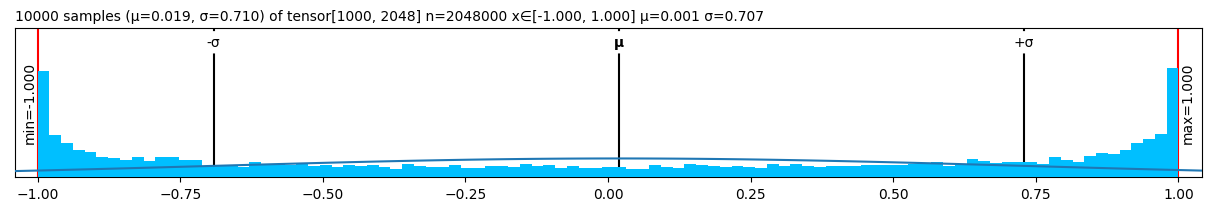

In [107]:
x_enc.plt

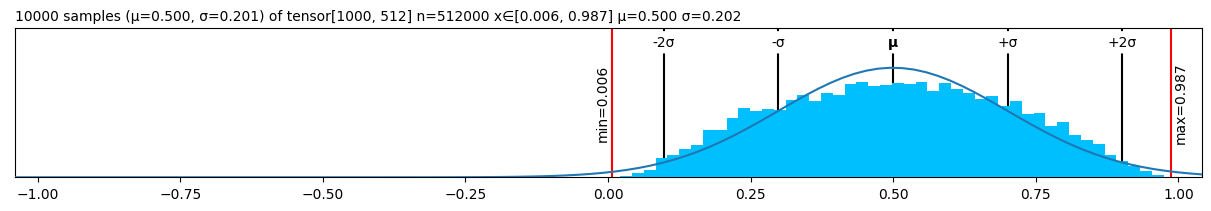

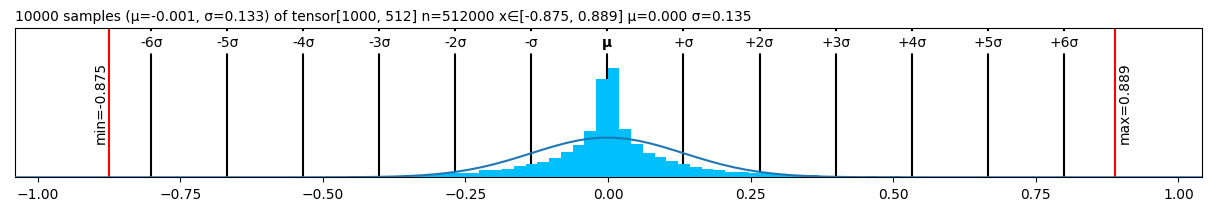

In [111]:
W1 = init_splitnet_layer_00_posenc_input(encoded_size*2, hidden_features*4, device='cpu')

# W2[:, :64] *= 2

W = W1
h = x_enc

Wtanh, Wsigm, Wsin, Wcos = W.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = h@Wtanh
preact_sigmoid = h@Wsigm
preact_sin = h@Wsin
preact_cos = h@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h1 = act_tanh*act_sigmoid*act_sin*act_cos

display(act_tanh.plt)
display(act_sigmoid.plt)
display(h1.plt)

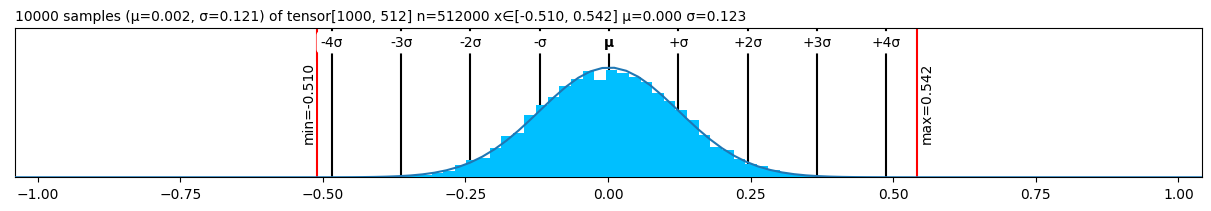

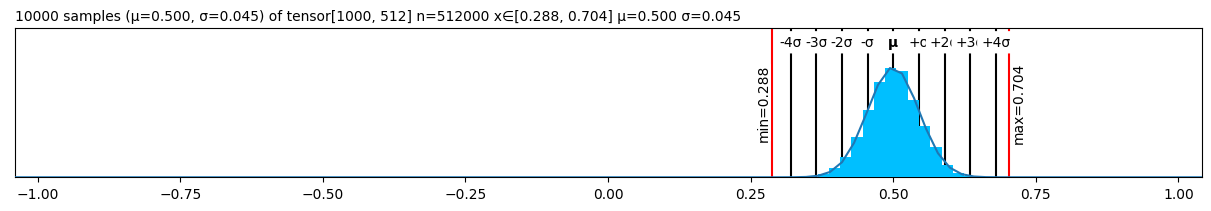

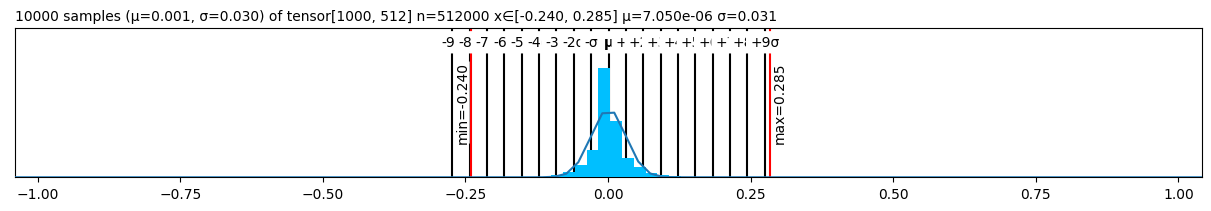

In [112]:
W2 = init_splitnet_layer_00_posenc_input(hidden_features, hidden_features*4, device='cpu')

# W2[:, :64] *= 2

W = W2
h = h1

Wtanh, Wsigm, Wsin, Wcos = W.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = h@Wtanh
preact_sigmoid = h@Wsigm
preact_sin = h@Wsin
preact_cos = h@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h2 = act_tanh*act_sigmoid*act_sin*act_cos

display(act_tanh.plt)
display(act_sigmoid.plt)
display(h2.plt)

In [113]:
W3 = init_splitnet_layer_00_posenc_input(hidden_features, 3, device='cpu')

# W2[:, :64] *= 2

W = W2
h = h2

Wtanh, Wsigm, Wsin, Wcos = W.chunk(4, dim=-1)
# btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

preact_tanh = h@Wtanh
preact_sigmoid = h@Wsigm
preact_sin = h@Wsin
preact_cos = h@Wcos

act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h3 = act_tanh*act_sigmoid*act_sin*act_cos

display(act_tanh.plt)
display(act_sigmoid.plt)
display(h3.plt)

AssertionError: 

### Distribution 

In [48]:
class EmpiricalDistribution:
    def __init__(self, samples):
        # 1. Convert the PyTorch tensor to a NumPy array
        samples_array = samples_tensor.flatten().numpy()

        # 2. Create a histogram from the samples
        hist, bin_edges = np.histogram(samples_array, bins='auto', density=True)

        # 3. Use the histogram to create an empirical cumulative distribution function (ECDF)
        cumulative_values = np.cumsum(hist)
        cumulative_values /= cumulative_values[-1]
        self.cumulative_values = cumulative_values
        
    def __call__(self, fan_in):
        def sample_from_ecdf(size):
            uniform_samples = np.random.uniform(0, 1, size)
            indices = np.searchsorted(self.cumulative_values, uniform_samples)
            return bin_edges[indices]
        
    
        n = 1000
        
        samples = sample_from_ecdf(n*fan_in)
        samples = torch.from_numpy(samples).reshape(n, fan_in)
        return samples

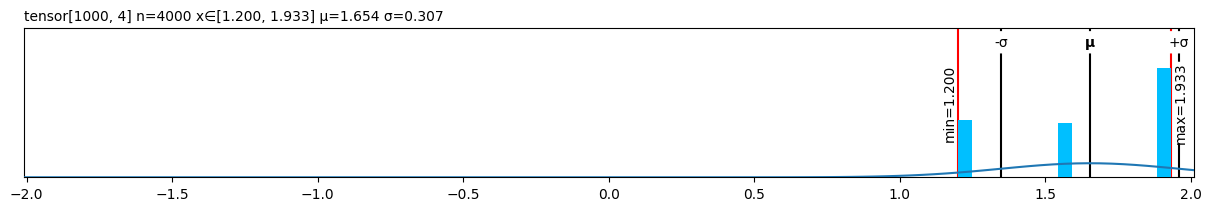

In [49]:
EmpiricalDistribution(h2)(4).plt

In [37]:
# Let's assume you have a tensor with samples from the custom distribution
samples_tensor = torch.tensor([1.2, 2.3, 2.0, 1.8])  # A 1D tensor with samples from your custom distribution

# 1. Convert the PyTorch tensor to a NumPy array
samples_array = samples_tensor.numpy()

# 2. Create a histogram from the samples
hist, bin_edges = np.histogram(samples_array, bins='auto', density=True)

# 3. Use the histogram to create an empirical cumulative distribution function (ECDF)
cumulative_values = np.cumsum(hist)
cumulative_values /= cumulative_values[-1]

def sample_from_ecdf(size):
    uniform_samples = np.random.uniform(0, 1, size)
    indices = np.searchsorted(cumulative_values, uniform_samples)
    return bin_edges[indices]

# 4. Sample from the ECDF
num_samples = 10  # The number of new samples you want to generate
new_samples = sample_from_ecdf(num_samples)
print(new_samples)

[1.9333333 1.9333333 1.2       1.2       1.9333333 1.9333333 1.9333333
 1.2       1.2       1.9333333]


# Local gradient excercise

- Lets calculate the local gradient. 
- I think we can check ourselves with autograd, if we use `h.sum().backward()`
- We are interested in `dW` and `db`
- OPEN QUESTION: DIFF IF DIFFERENT CHUNKING
- TODO: do the same excercise on siren first layer (reproduce the plot from the paper)

In [29]:
def init_splitact_Wb_randn(insize, outsize, device='cpu'):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)*0.001
    return W, b

In [30]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [31]:
outsize = 64
W, b = init_splitact_Wb_randn(insize=encoded_size*2, outsize=outsize)

W.requires_grad = True
b.requires_grad = True
x = uvs_enc.clone()

In [32]:
x, W, b

(tensor[262144, 4] n=1048576 x∈[-1.000, 1.000] μ=-0.000 σ=0.707,
 tensor[4, 256] n=1024 x∈[-2.907, 3.177] μ=0.031 σ=1.014 grad,
 tensor[256] x∈[-0.003, 0.002] μ=-3.192e-05 σ=0.001 grad)

In [33]:
preact = x@W + b
p = preact.chunk(4, dim=-1)

In [34]:
Wtanh, Wsigm, Wsin, Wcos = W.chunk(4, dim=-1)
btanh, bsigm, bsin, bcos = b.chunk(4, dim=-1)

In [35]:
preact_tanh = x@Wtanh + btanh
preact_sigmoid = x@Wsigm + bsigm
preact_sin = x@Wsin + bsin
preact_cos = x@Wcos + bcos

In [36]:
(p[2] - preact_sin)

tensor[262144, 64] all_zeros grad SubBackward0

In [37]:
# preact = x@W + b
# preact_tanh, preact_sigmoid, preact_sin, preact_cos = preact.chunk(4, dim=-1)
act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
h = act_tanh*act_sigmoid*act_sin*act_cos

for t in [preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos, Wtanh, Wsigm, Wsin, Wcos]:
    t.retain_grad()

h.mean().backward()

In [38]:
preact_cos

tensor[262144, 64] n=16777216 x∈[-4.837, 4.836] μ=-5.242e-05 σ=1.399 grad AddBackward0

In [39]:
Wcos

tensor[4, 64] n=256 x∈[-2.857, 3.136] μ=0.104 σ=0.985 grad SplitBackward0

In [40]:
# dpreact_tanh = 

dact_sin = act_tanh*act_sigmoid*act_cos / outsize/262144
dact_cos = act_tanh*act_sigmoid*act_sin / outsize/262144
dact_tanh = act_sigmoid*act_sin*act_cos / outsize/262144
dact_sigmoid = act_tanh*act_sin*act_cos / outsize/262144

dpreact_sin = preact_sin.cos() * dact_sin
dpreact_cos = (-preact_cos.sin()) * dact_cos
dpreact_tanh = (1. - act_tanh**2.0) * dact_tanh
dpreact_sigmoid = act_sigmoid*(1-act_sigmoid)*dact_sigmoid

dWcos = x.T @ dpreact_cos
dWsin = x.T @ dpreact_sin
dWtanh = x.T @ dpreact_tanh
dWsigm = x.T @ dpreact_sigmoid

cmp('act_sin', dact_sin, act_sin)
cmp('act_cos', dact_cos, act_cos)
cmp('act_tanh', dact_tanh, act_tanh)
cmp('act_sigmoid', dact_sigmoid, act_sigmoid)

cmp('preact_sin', dpreact_sin, preact_sin)
cmp('preact_cos', dpreact_cos, preact_cos)
cmp('preact_tanh', dpreact_tanh, preact_tanh)
cmp('preact_sigmoid', dpreact_sigmoid, preact_sigmoid)



cmp('Wcos', dWcos, Wcos)
cmp('Wsin', dWsin, Wsin)
cmp('Wtanh', dWtanh, Wtanh)
cmp('Wsigm', dWsigm, Wsigm)

act_sin         | exact: True  | approximate: True  | maxdiff: 0.0
act_cos         | exact: True  | approximate: True  | maxdiff: 0.0
act_tanh        | exact: False | approximate: True  | maxdiff: 3.552713678800501e-15
act_sigmoid     | exact: False | approximate: True  | maxdiff: 3.552713678800501e-15
preact_sin      | exact: True  | approximate: True  | maxdiff: 0.0
preact_cos      | exact: True  | approximate: True  | maxdiff: 0.0
preact_tanh     | exact: False | approximate: True  | maxdiff: 7.105427357601002e-15
preact_sigmoid  | exact: False | approximate: True  | maxdiff: 2.6645352591003757e-15
Wcos            | exact: True  | approximate: True  | maxdiff: 0.0
Wsin            | exact: True  | approximate: True  | maxdiff: 0.0
Wtanh           | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10
Wsigm           | exact: False | approximate: True  | maxdiff: 1.7053025658242404e-12


# Local gradient for SIREN

In [41]:
! nvidia-smi

Sun Apr 23 10:52:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |  12237MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [42]:
TODO

NameError: name 'TODO' is not defined